In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
from IPython.display import clear_output

In [116]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from matplotlib.colors import LogNorm
from tqdm import tqdm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count, product

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (10, 8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

In [7]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [8]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return (int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [19]:
def plot_board(env, pi, compliance, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s_prime, actions = env.getHash(), env.getEmptySpaces()
    s = compliance[s_prime]
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
#     cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
#     plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [22]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=False, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

# Часть первая: крестики-нолики при помощи Q-обучения

In [410]:
def get_random_q(env):
    state_size = 3 ** (env.n_cols * env.n_rows)
    action_size = env.n_cols * env.n_rows
    Q_cross = np.random.random(size=(state_size, action_size))
    Q_naught = np.random.random(size=(state_size, action_size))
    compliance = {}
    idx = 0
    for state in product("012", repeat=env.n_cols * env.n_rows):
        compliance["".join(state)] = idx
        idx += 1
    return Q_cross, Q_naught, compliance

def compute_policy_by_q(env, Q, state, possible_actions):
    mask = np.ones(Q.shape[1]) * np.nan
    for act in possible_actions:
        mask[act[0] * env.n_rows + act[1]] = 1
    temp_q_values = list(filter(lambda x: not np.isnan(x), Q[state] * mask))
    return np.argmax(temp_q_values)

def q_learning_episode(env, 
                       Q_cross, 
                       Q_naught, 
                       compliance, 
                       alpha, 
                       epsilon, 
                       gamma, 
                       estimate=False,
                       random_cross=False,
                       random_naught=False):
    done_cross = False
    done_naught = False
    env.reset()
    cross_prev_state, naught_prev_state = None, None
    cross_cur_state, naught_cur_state = None, None
    
    # cross action
    cross_cur_state, cross_actions = env.getHash(), env.getEmptySpaces()
    a0 = compute_policy_by_q(env, Q_cross, compliance[cross_cur_state], cross_actions) \
         if (np.random.rand() > epsilon or estimate) and (not random_cross) \
         else np.random.choice(range(len(cross_actions)))
    naught_prev_state = naught_cur_state
    (naught_cur_state, _, _), reward_cross, done_cross, info = env.step(cross_actions[a0])
    
    # naught action
    naught_actions = env.getEmptySpaces()
    a1 = compute_policy_by_q(env, Q_naught, compliance[naught_cur_state], naught_actions) \
         if (np.random.rand() > epsilon or estimate) and (not random_naught) \
         else np.random.choice(range(len(naught_actions)))
    cross_prev_state = cross_cur_state
    (cross_cur_state, _, _), reward_naught, done_naught, info = env.step(naught_actions[a1])
    
    for _ in range(1000):
        if not estimate:
            a_indx = cross_actions[a0][0] * env.n_rows + cross_actions[a0][1]
            if done_naught:
                reward_cross = reward_naught
            Q_cross[compliance[cross_prev_state]][a_indx] = Q_cross[compliance[cross_prev_state]][a_indx] \
                    + alpha * (reward_cross + gamma 
                               * np.max(Q_cross[compliance[cross_cur_state]]) - Q_cross[compliance[cross_prev_state]][a_indx])
        if done_naught:
            if naught_prev_state is not None and not estimate:
                a_indx_naught = naught_actions[a1][0] * env.n_rows + naught_actions[a1][1]
                Q_naught[compliance[naught_prev_state]][a_indx_naught] = Q_naught[compliance[naught_prev_state]][a_indx_naught] \
                    + alpha * (-reward_naught - Q_naught[compliance[naught_prev_state]][a_indx_naught])
            break
            
        cross_prev_state = cross_cur_state
        cross_cur_state, cross_actions = env.getHash(), env.getEmptySpaces()
        a0 = compute_policy_by_q(env, Q_cross, compliance[cross_cur_state], cross_actions) \
             if (np.random.rand() > epsilon or estimate) and (not random_cross) \
             else np.random.choice(range(len(cross_actions)))
        naught_prev_state = naught_cur_state
        (naught_cur_state, _, _), reward_cross, done_cross, info = env.step(cross_actions[a0])  
        
        if not estimate:
            if done_cross:
                reward_naught = reward_cross
            a_indx_naught = naught_actions[a1][0] * env.n_rows + naught_actions[a1][1]
            Q_naught[compliance[naught_prev_state]][a_indx_naught] = Q_naught[compliance[naught_prev_state]][a_indx_naught] \
                + alpha * (-reward_naught + gamma  
                           * np.max(Q_naught[compliance[naught_cur_state]]) - Q_naught[compliance[naught_prev_state]][a_indx_naught])
        if done_cross:
            if not estimate:
                a_indx = cross_actions[a0][0] * env.n_rows + cross_actions[a0][1]
                Q_cross[compliance[cross_prev_state]][a_indx] = Q_cross[compliance[cross_prev_state]][a_indx] \
                        + alpha * (reward_cross - Q_cross[compliance[cross_prev_state]][a_indx])
            break  
            
        naught_actions = env.getEmptySpaces()
        a1 = compute_policy_by_q(env, Q_naught, compliance[naught_cur_state], naught_actions) \
             if (np.random.rand() > epsilon or estimate) and (not random_naught) \
             else np.random.choice(range(len(naught_actions)))
        cross_prev_state = cross_cur_state
        (cross_cur_state, _, _), reward_naught, done_naught, info = env.step(naught_actions[a1])
    if done_cross:
        return reward_cross, -reward_cross
    else:
        return reward_naught, -reward_naught

def run_qlearning(env, 
                  total_episodes=25000, 
                  alpha=0.05, 
                  epsilon=0.0, 
                  gamma=0.9, 
                  return_rewards=False, 
                  verbose=10000,
                  random_cross=False,
                  random_naught=False):
    Q_cross, Q_naught, compliance = get_random_q(env)
    cross_mean_rewards = []
    naught_mean_rewards = []
    cross_cur_mean_reward = 0
    naught_cur_mean_reward = 0
    amount_of_rewards = 0
    cross_min_reward = 100
    naught_min_reward = 100
    for idx, _ in tqdm(enumerate(range(total_episodes + 1))):
        q_learning_episode(env, Q_cross, Q_naught, compliance, alpha, epsilon, gamma, 
                           random_cross=random_cross, random_naught=random_naught)
        # estimating strategy
        cross_reward, naught_reward = q_learning_episode(env, Q_cross, Q_naught, compliance, alpha, epsilon, 
                                                         gamma, estimate=True, 
                                                         random_cross=random_cross, random_naught=random_naught)
        cross_cur_mean_reward = (cross_cur_mean_reward * amount_of_rewards + cross_reward) / (amount_of_rewards + 1)
        naught_cur_mean_reward = (naught_cur_mean_reward * amount_of_rewards + naught_reward) / (amount_of_rewards + 1)
        amount_of_rewards += 1
        if cross_min_reward > cross_cur_mean_reward:
            cross_min_reward = cross_cur_mean_reward
        if naught_min_reward > naught_cur_mean_reward:
            naught_min_reward = naught_cur_mean_reward
        cross_mean_rewards.append(cross_cur_mean_reward)
        naught_mean_rewards.append(naught_cur_mean_reward)
        if idx % verbose == 0:
            clear_output(True)
            fig, ax = plt.subplots(1, 1, figsize=(8, 5))
            ax.set_yticks(np.arange(-10, 10, 1.0))
            ax.set_title(f"Mean reward")
            ax.set_xlabel("Games played")
            ax.set_ylabel("Cumulative mean reward")
            ax.plot(cross_mean_rewards, label=f"Last cumulative mean reward for crosses = {cross_mean_rewards[-1]:.3f}")
            ax.plot(naught_mean_rewards, label=f"Last cumulative mean reward for naughts = {naught_mean_rewards[-1]:.3f}")
            ax.legend()
            plt.show()
    env.close()
    if return_rewards:
        return Q_cross, Q_naught, cross_mean_rewards, naught_mean_rewards
    return Q_cross, Q_naught

## Random naughts, fitting crosses

In [427]:
TOTAL_EPISODES = 50000
ALPHA = 0.5
EPSILON = 0.5
GAMMA = 1
RANDOM_CROSS = False
RANDOM_NAUGHT = True

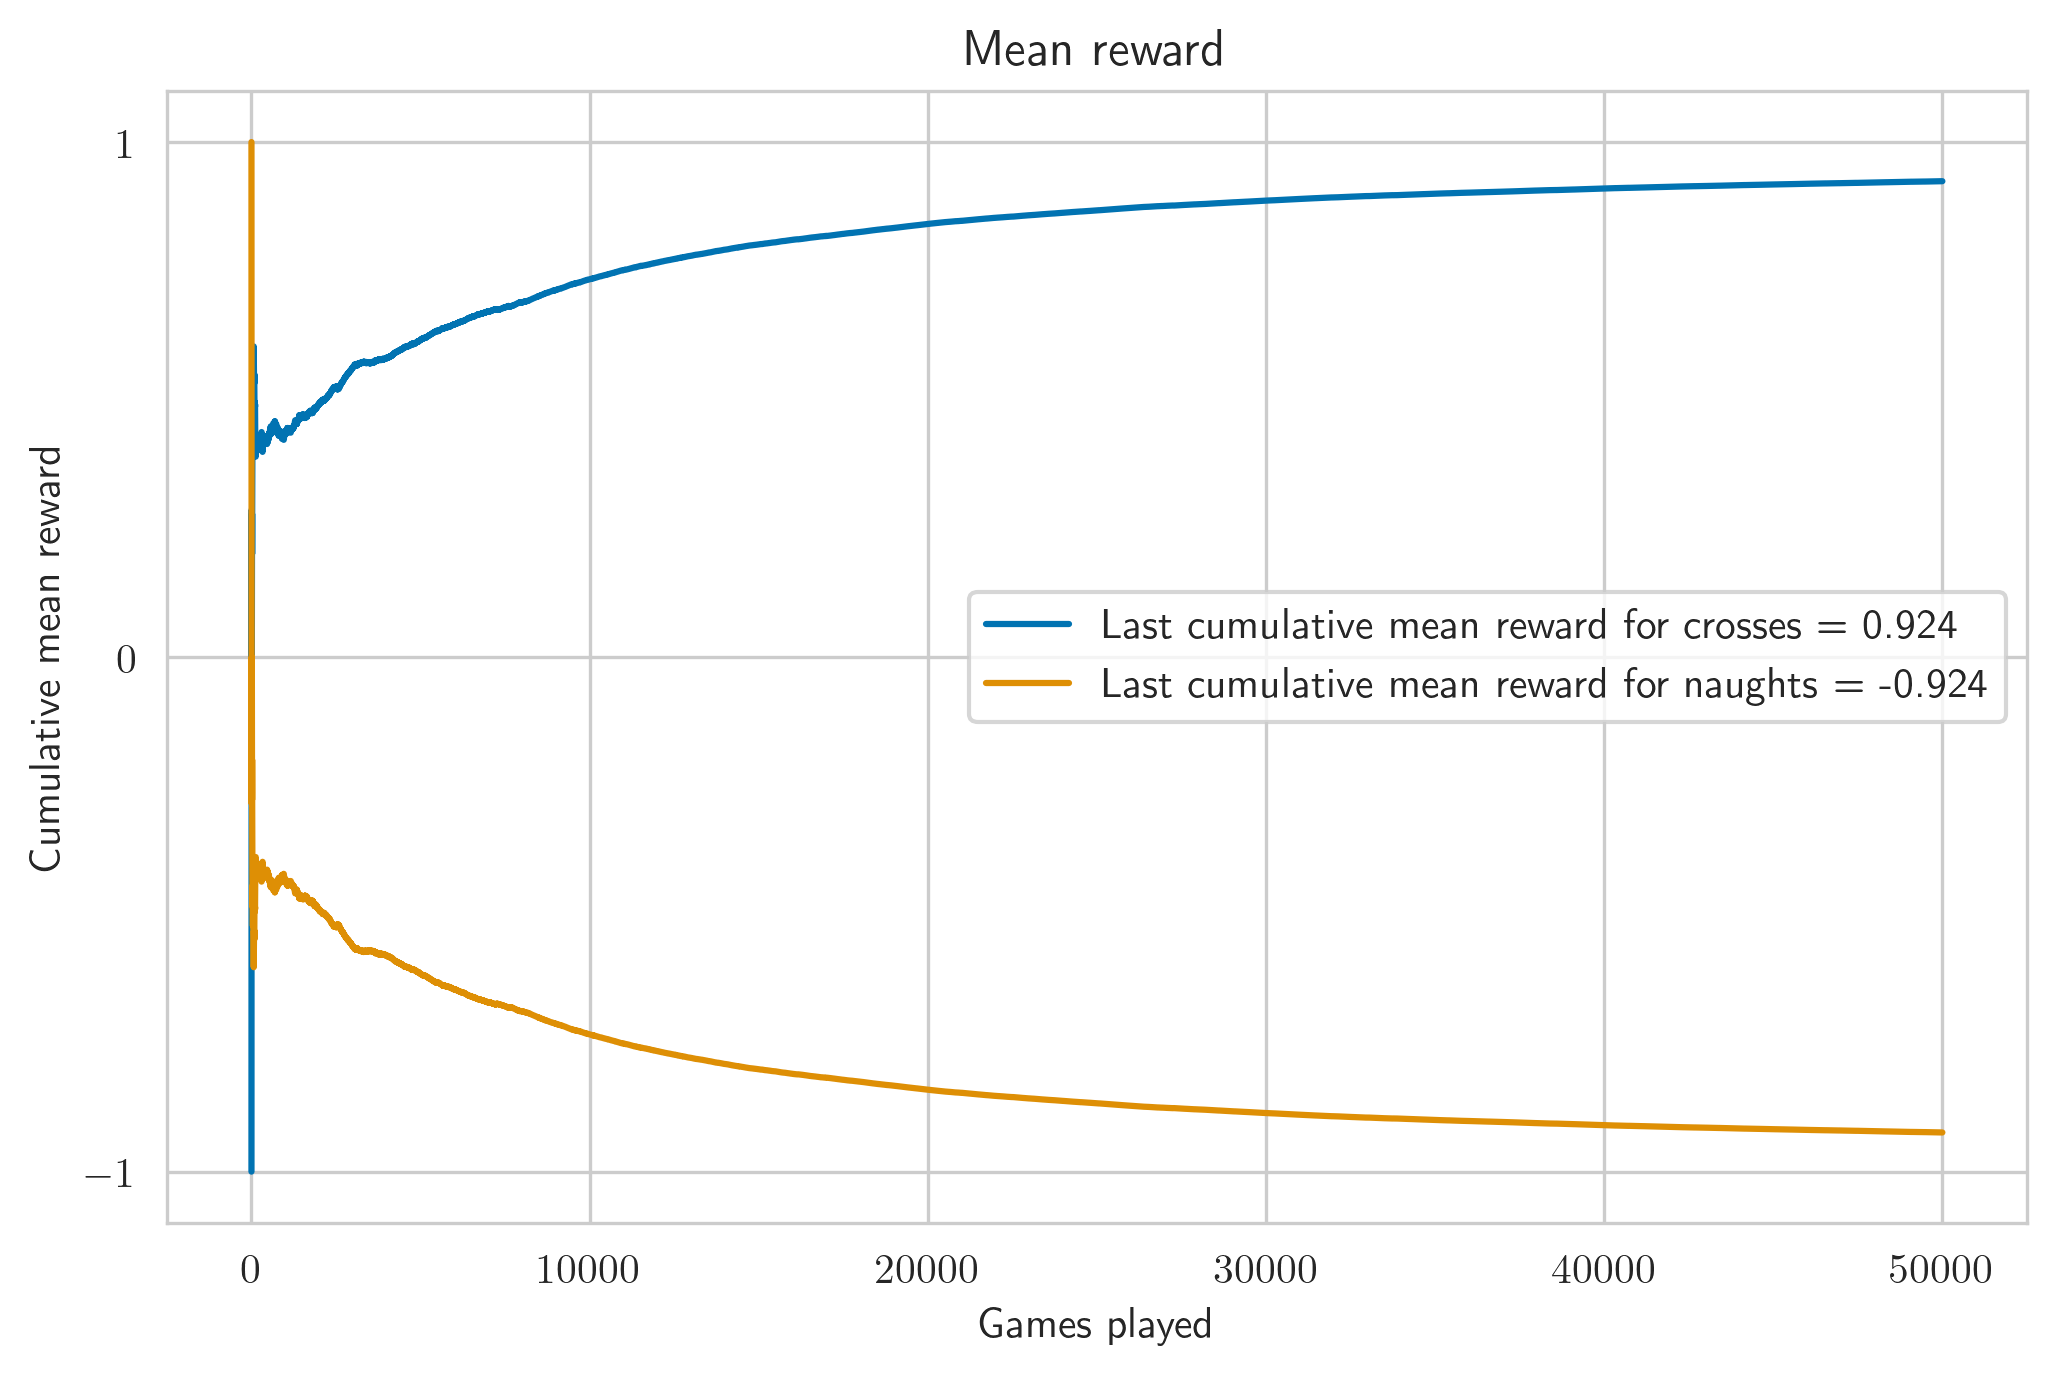

50001it [00:50, 987.12it/s] 


In [428]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
fitted_q_cross, random_q_naught = run_qlearning(env, total_episodes=TOTAL_EPISODES, alpha=ALPHA, 
                                                epsilon=EPSILON, gamma=GAMMA, return_rewards=False, 
                                                verbose=5000, random_cross=RANDOM_CROSS, random_naught=RANDOM_NAUGHT)

### Крестики научились отлично обыгрывать нолики.

## Random crosses, fitting naughts

In [454]:
TOTAL_EPISODES = 50000
ALPHA = 0.5
EPSILON = 0.5
GAMMA = 1
RANDOM_CROSS = True
RANDOM_NAUGHT = False

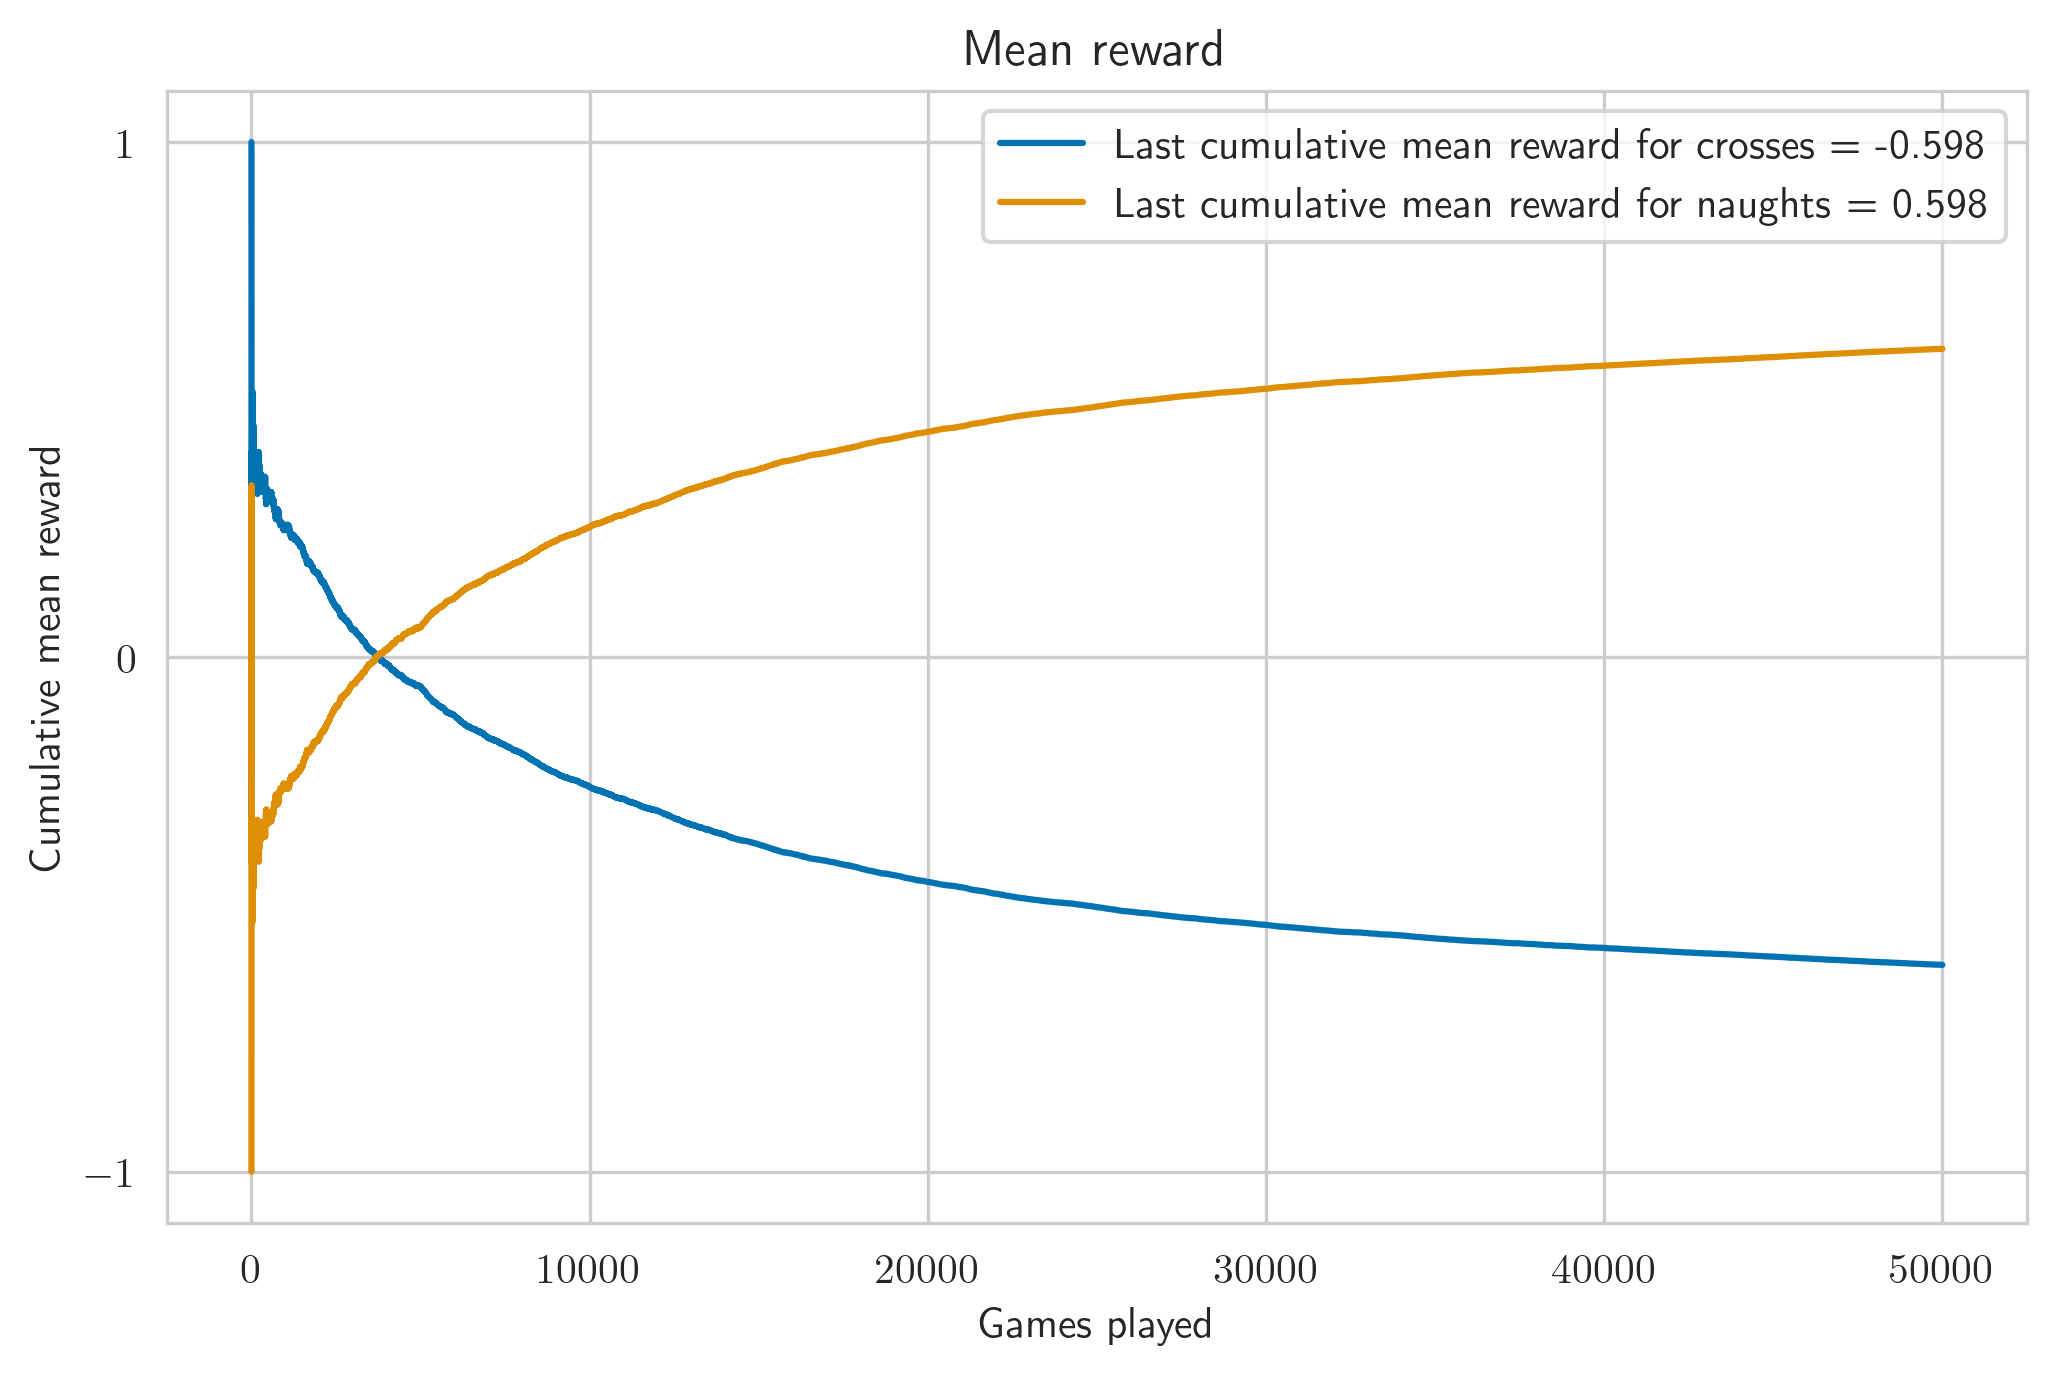

50001it [00:52, 952.95it/s] 


In [455]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
random_q_cross, fitted_q_naught = run_qlearning(env, total_episodes=TOTAL_EPISODES, alpha=ALPHA, 
                                                epsilon=EPSILON, gamma=GAMMA, return_rewards=False, 
                                                verbose=5000, random_cross=RANDOM_CROSS, random_naught=RANDOM_NAUGHT)

### В свою очередь, нолики научились обыгрывать крестики, если те играют по случайной стратегии.

## Fitting crosses, fitting naughts

In [467]:
TOTAL_EPISODES = 50000
ALPHA = 0.05
EPSILON = 0.5
GAMMA = 1
RANDOM_CROSS = False
RANDOM_NAUGHT = False

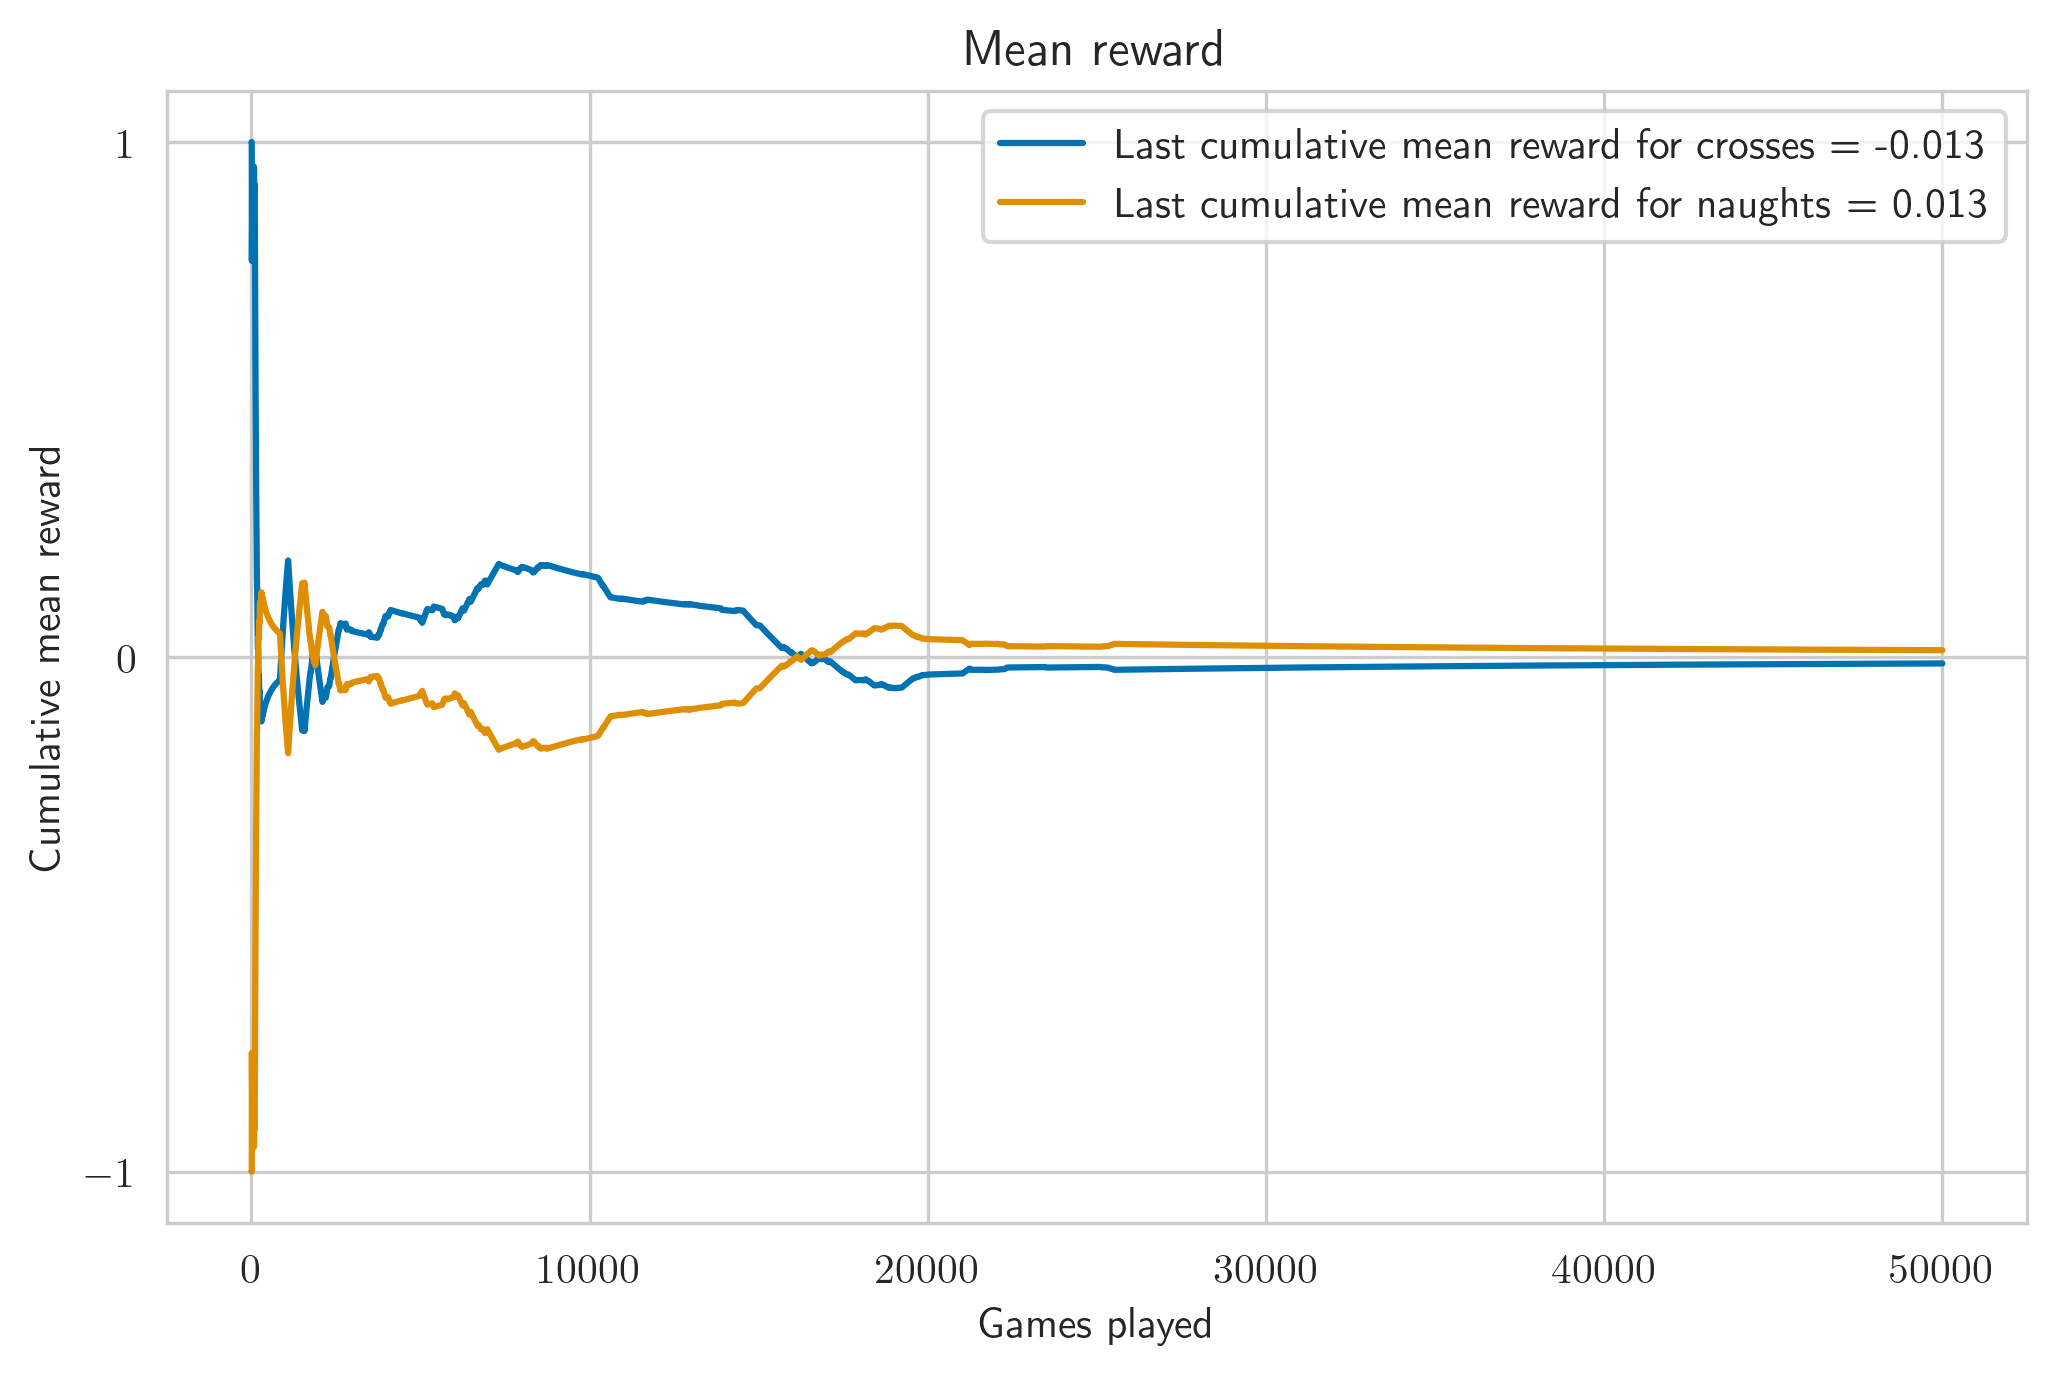

50001it [01:06, 756.70it/s]


In [468]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
random_q_cross, fitted_q_naught = run_qlearning(env, total_episodes=TOTAL_EPISODES, alpha=ALPHA, 
                                                epsilon=EPSILON, gamma=GAMMA, return_rewards=False, 
                                                verbose=5000, random_cross=RANDOM_CROSS, random_naught=RANDOM_NAUGHT)

### Можно заметить, что если крестики и нолики будут учиться оптимально играть друг против друга без случайных политик, то средняя кумулятивная награда каждого из них будет сходиться к нулю.

# Часть вторая: добавим нейронных сетей